In [127]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.special as special
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import pytorch_lightning as pl
import tqdm
sns.set()
import os
os.chdir('/Users/harshparikh/Documents/GitHub/credence-to-causal-estimation/credence-v2/src/')
import credence
import autoencoder
import importlib
importlib.reload(autoencoder)
importlib.reload(credence)
os.chdir('/Users/harshparikh/Documents/GitHub/credence-to-causal-estimation/credence-v2/notebooks/')
from econml.dml import NonParamDML
from sklearn.linear_model import LinearRegression, RidgeCV, LogisticRegressionCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from econml.metalearners import TLearner, SLearner, XLearner, DomainAdaptationLearner

# DGP1

In [130]:
def dgp1(n=1000,p=10,r=0):
    X = np.random.normal(0,1,size=(n,p))
    Y0 = np.sum(X,axis=1) + np.random.normal(0,1,size=(n))
    Y1 = Y0**2 + np.random.normal(np.mean(X,axis=1),5)
    TE = Y1-Y0
    pi =  special.expit( r*(np.sum(X,axis=1)) )
    T = np.random.binomial(1,pi)
    df = pd.DataFrame(X,columns=['X%d'%(i) for i in range(X.shape[1])])
    df['Y'] = T*Y1 + (1-T)*Y0
    df['T'] = T
    df_true = df.copy(deep=True)
    df_true['Y0'] = Y0
    df_true['Y1'] = Y1
    df_true['TE'] = TE
    df_true['pi'] = pi
    return df, df_true

n=1000
p=10
df, df_true = dgp1(n,p,r=0.5)

sns.scatterplot(y='Y0',x='Y1',hue='T',data=df_true,alpha=0.4)

In [160]:
bias_df = []
n=2500
p=10
df_prop_score = pd.DataFrame()
for r in np.arange(0,5):
    df_gen,df_gen_true = dgp1(n,p,r=r/10.0)
    df_prop_score_r = df_gen[['T']].copy(deep=True)
    df_prop_score_r['pi'] = df_gen_true['pi']
    df_prop_score_r['r'] = r/10.0
    df_prop_score = df_prop_score.append(df_prop_score_r,ignore_index=True)
    
    repeat=100
    continuous_vars = ['X%d'%(i) for i in range(p)]+['Y']
    categorical_var=['T']

    Bias_truedgp = []
    for itr in tqdm.tqdm(range(repeat)):
        Bias_est = {}
        df_gen,df_gen_true = dgp1(n,p,r=r/10.0)

    #     df_gen['Y'] = df_gen['T']*df_gen['Y1'] + (1-df_gen['T'])*df_gen['Y0']

        true_te = df_gen_true['TE']
        selection_bias = 0 #df_gen_prime['T']*(df_gen_prime['Y1'] - df_gen_prime['Yprime1']) + (1-df_gen_prime['T'])*(df_gen_prime['Yprime0'] - df_gen_prime['Y0']) 
    #     Bias_est['True-TE'] = true_te.mean()
    #     Bias_est['selection-bias'] = selection_bias.mean()

    #     df_gen = df_gen.drop(columns=['Y0','Y1'])

        Bias_est['Naive-Diff'] = (df_gen.loc[df_gen['T']==1,'Y'].mean() - df_gen.loc[df_gen['T']==0,'Y'].mean()) - (true_te+selection_bias).mean()
        #     print(ATE_est['Naive-Diff'])

        est = NonParamDML(model_y=GradientBoostingRegressor(),
                          model_t=GradientBoostingClassifier(),
                          model_final=GradientBoostingRegressor(),discrete_treatment=True)
        est.fit(df_gen['Y'], 
                df_gen['T'], 
                X=df_gen.drop(columns=['Y','T']), 
                W=df_gen.drop(columns=['Y','T']))
        point = est.ate(df_gen.drop(columns=['Y','T']), 
                        T0=0, T1=1)

        Bias_est['NonParameteric DML'] = point - (true_te+selection_bias).mean()
        #     print(ATE_est['NonParameteric DML'])

        models = GradientBoostingRegressor()
        T_learner = TLearner(models=models)
        T_learner.fit(df_gen['Y'], df_gen['T'], X=df_gen.drop(columns=['Y','T']))
        point = T_learner.ate(X=df_gen.drop(columns=['Y','T']))
        Bias_est['T-Learner'] = point  - (true_te+selection_bias).mean()
        #     print(ATE_est['T-Learner'])

        models = GradientBoostingRegressor()
        S_learner = SLearner(overall_model=models)
        S_learner.fit(df_gen['Y'], df_gen['T'], X=df_gen.drop(columns=['Y','T']))
        point = S_learner.ate(X=df_gen.drop(columns=['Y','T']))
        Bias_est['S-Learner'] = point  - (true_te+selection_bias).mean()
        #     print(ATE_est['S-Learner'])

        models = GradientBoostingRegressor()
        propensity_model = LogisticRegressionCV()
        X_learner = XLearner(models=models,propensity_model=propensity_model)
        X_learner.fit(df_gen['Y'], df_gen['T'], X=df_gen.drop(columns=['Y','T']))
        point = X_learner.ate(X=df_gen.drop(columns=['Y','T']))
        Bias_est['X-Learner'] = point - (true_te+selection_bias).mean()
        #     print(ATE_est['X-Learner'])

        df_bias = pd.DataFrame.from_dict(Bias_est,orient='index',columns=['TE'])

        Bias_truedgp += [df_bias]

    Bias_truedgp = pd.concat(Bias_truedgp,axis=1)
    Bias_truedgp['r'] = r/10.0
    bias_df += [Bias_truedgp]
bias_df = pd.concat(bias_df)

100%|██████████| 100/100 [08:23<00:00,  5.04s/it]
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
100%|██████████| 100/100 [08:41<00:00,  5.22s/it]
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
100%|██████████| 100/100 [08:31<00:00,  5.11s/it]
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
100%|██████████| 100/100 [08:24<00:00,  5.05s/it]
DataFrame is highly fragme

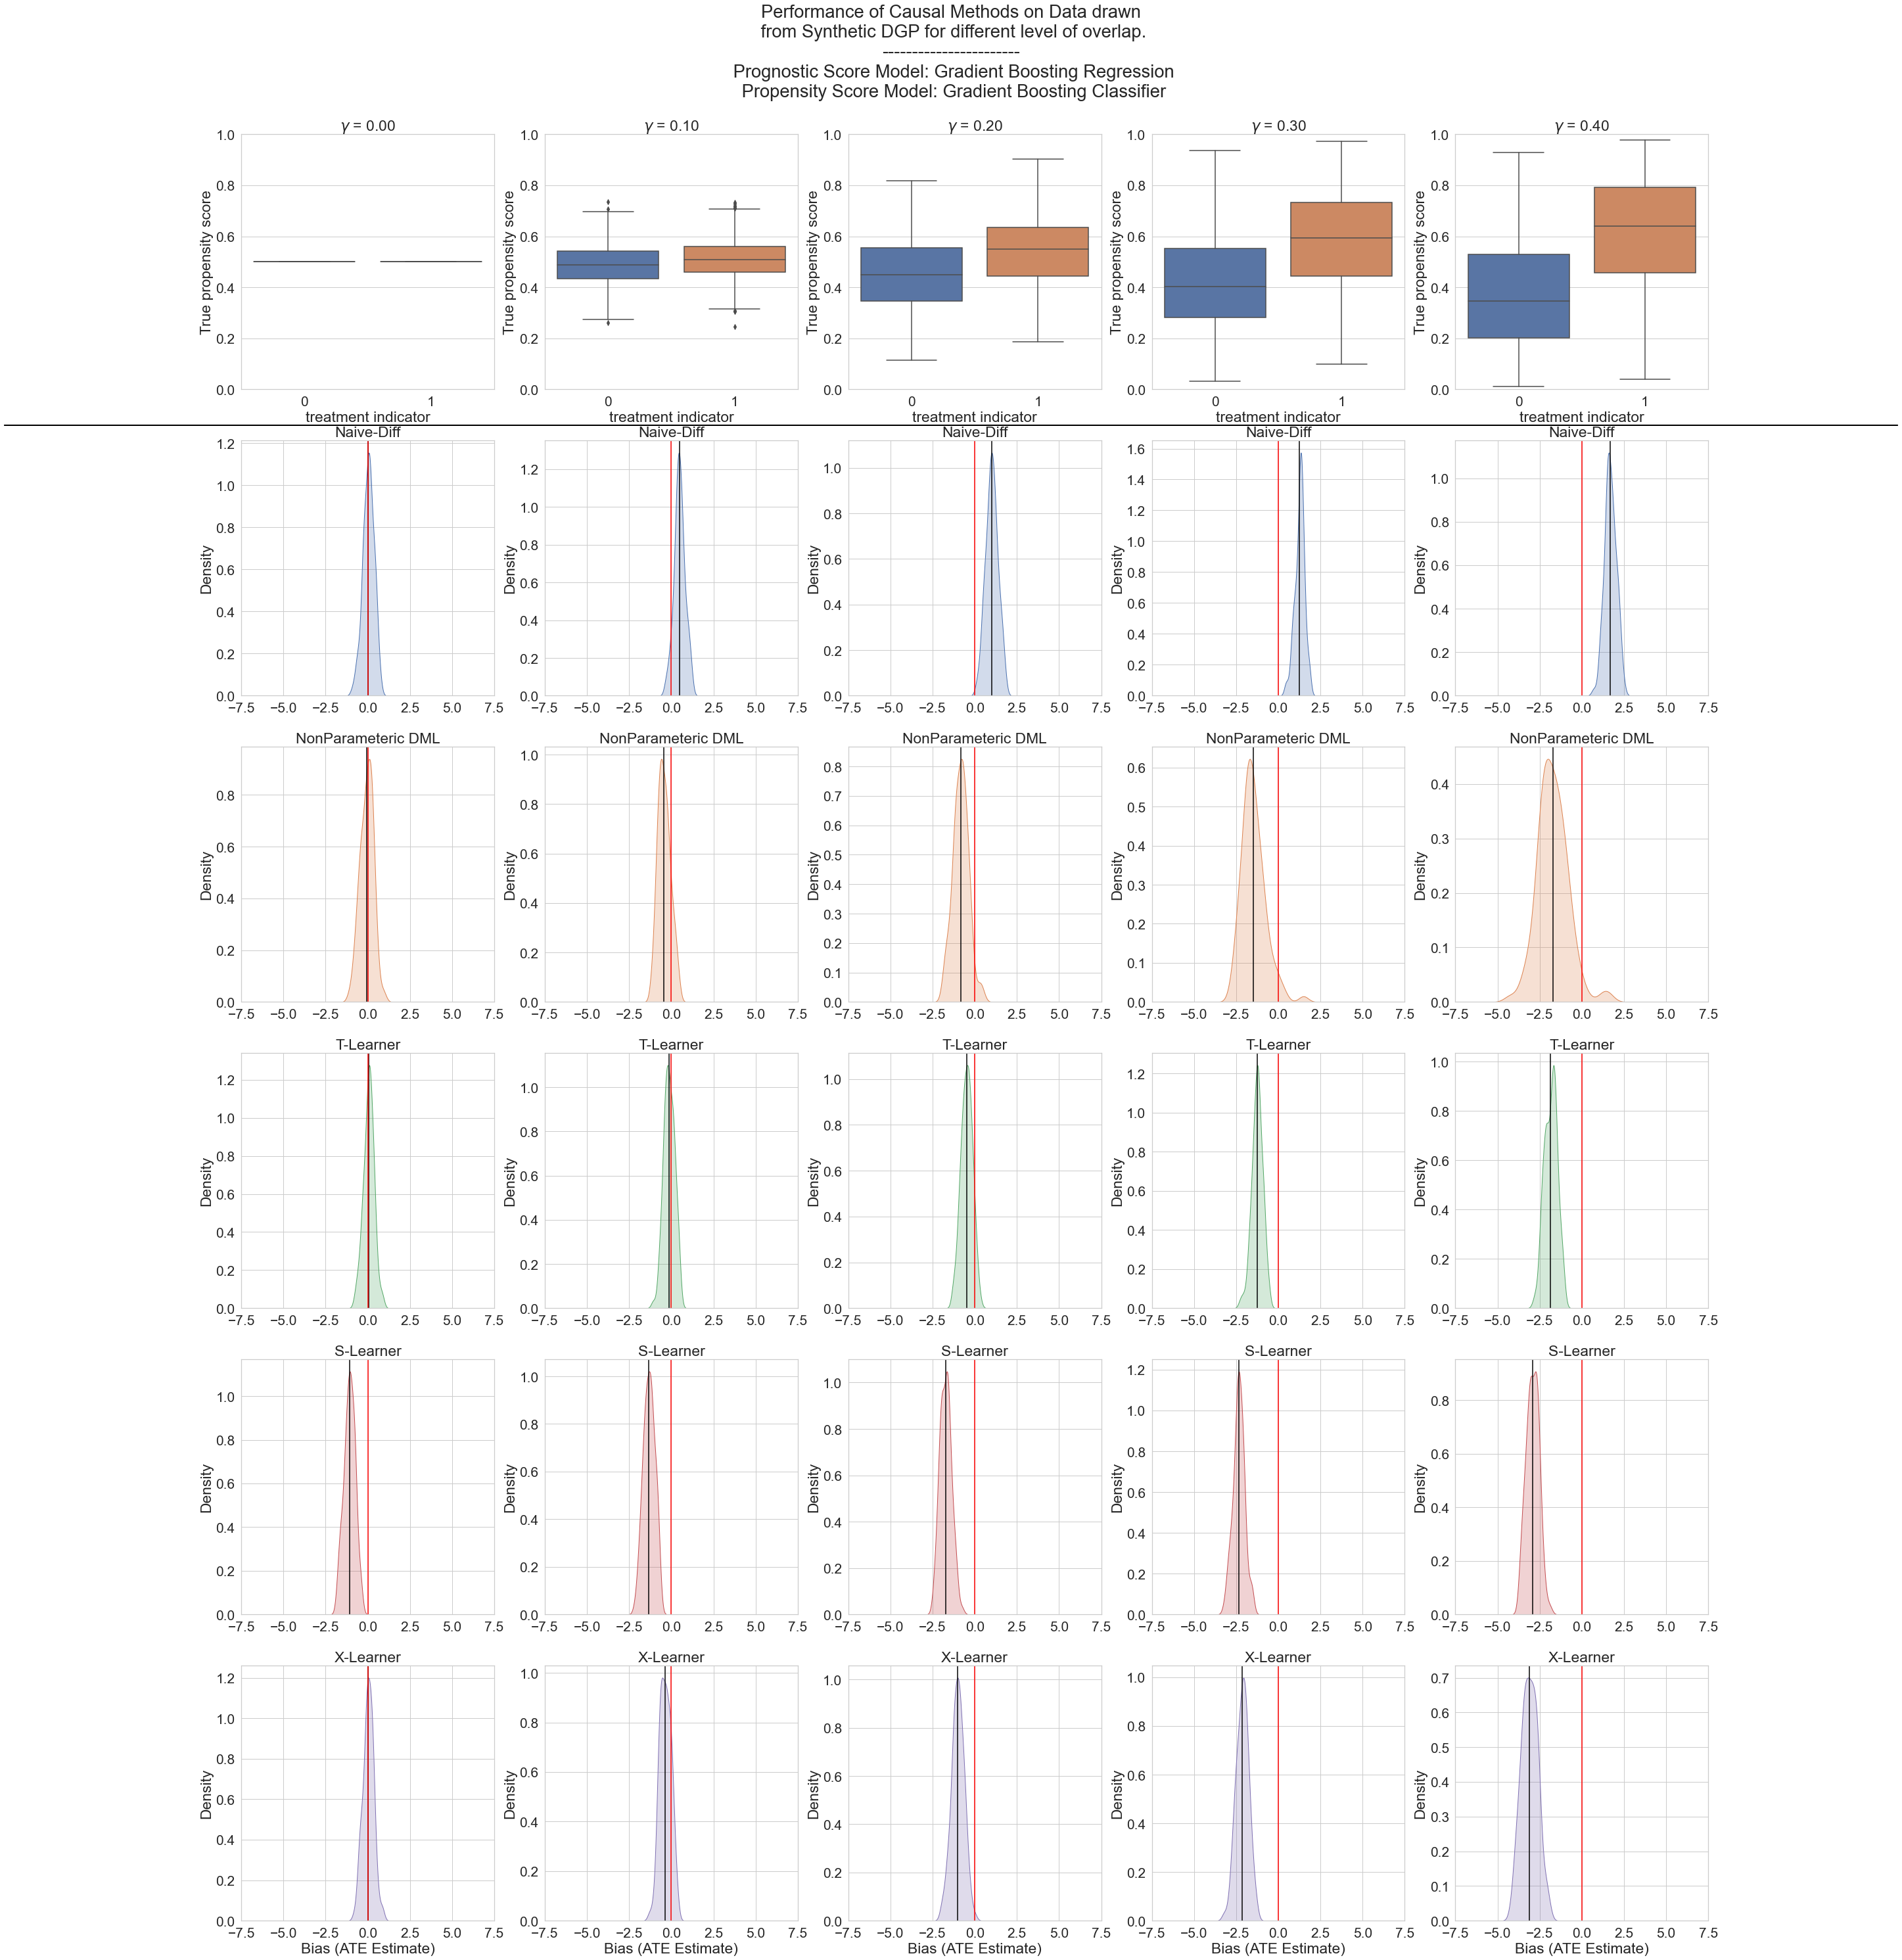

In [178]:
sns.set(style='whitegrid',font_scale=1.9)
Bias_truedgp = bias_df.loc[bias_df['r']==r/10.0].drop(columns=['r'])
fig,ax = plt.subplots(figsize=(40,50),nrows=Bias_truedgp.shape[0]+1,ncols=5,sharex=False,sharey=False)
plt.suptitle('Performance of Causal Methods on Data drawn\n from Synthetic DGP for different level of overlap.\n-----------------------\n Prognostic Score Model: Gradient Boosting Regression\n Propensity Score Model: Gradient Boosting Classifier',
             va='top',ha='center',y=0.935)
for r in range(5):
    sns.boxplot(data=df_prop_score.loc[df_prop_score['r']==r/10.0],x='T',y='pi',ax=ax[0,r])
    ax[0,r].set_ylim((0,1))
    ax[0,r].set_title('$\gamma$ = %.2f'%(r/10.0))
    ax[0,r].set_ylabel('True propensity score')
    ax[0,r].set_xlabel('treatment indicator')
    Bias_truedgp = bias_df.loc[bias_df['r']==r/10.0].drop(columns=['r'])
    line = plt.Line2D([0,1],[0.757,0.757], transform=fig.transFigure, color="black")
    fig.add_artist(line)
    for i in range(Bias_truedgp.shape[0]):
        row = Bias_truedgp.iloc[i]
        sns.kdeplot(row,ax=ax[i+1,r],fill=True,color='C%d'%(i))
        ax[i+1,r].axvline(np.mean(row),c='black')
        ax[i+1,r].set_title(bias_df.index[i])
        ax[i+1,r].axvline(0,c='red')
        ax[i+1,r].set_xlim((-7.5,7.5))
        if (i+1)<Bias_truedgp.shape[0]:
            ax[i+1,r].set_xlabel('')
        else:
            ax[i+1,r].set_xlabel('Bias (ATE Estimate)')
    # plt.xlim((-20,20))
plt.xlabel('Bias (ATE Estimate)')
plt.savefig('true_synth_perf.png')

# Credence

In [ ]:
v = {}
for r in tqdm.tqdm(np.arange(0,5)):
    df_gen,df_gen_true = dgp1(n,p,r=r/10.0)
    v[r] = credence.Credence(data=df_gen, # dataframe 
                          post_treatment_var=['Y'], # list of post treatment variables
                          treatment_var=['T'], # list of treatment variable(s)
                          categorical_var=['T'], # list of variables which are categorical
                          numerical_var=['X%d'%(i) for i in range(p)]+['Y'] # list of variables which are numerical
                        )

    gen = v[r].fit(effect_rigidity=0,bias_rigidity=5000,kld_rigidity=0.02,max_epochs=1000)

    v[r].trainer_treat.save_checkpoint("synth_treat_%d.ckpt"%(r))
    v[r].trainer_pre.save_checkpoint("synth_pre_%d.ckpt"%(r))
    v[r].trainer_post.save_checkpoint("synth_post_%d.ckpt"%(r))

  0%|          | 0/5 [00:00<?, ?it/s]GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 32    
1 | en_mu     | Linear     | 34    
2 | en_logvar | Linear     | 34    
3 | decoder   | Sequential | 48    
4 | decode_Y  | Linear     | 17    
-----------------------------------------
165       Trainable params
0         Non-trainable params
165       Total params
0.001     Total estimated model params size (MB)
Your val_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.


Validation sanity check: 0it [00:00, ?it/s]

The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

# Read Trained Credence Objects

# Performance on Credence Generated Data

In [193]:
df_bias_bootstrap = []
df_prop_score = pd.DataFrame()
    
for r in tqdm.tqdm(np.arange(0,5)):
    df,df_true = dgp1(n,p,r=r/10.0)
    df_prop_score_r = df[['T']].copy(deep=True)
    df_prop_score_r['pi'] = df_true['pi']
    df_prop_score_r['r'] = r/10.0
    df_prop_score = df_prop_score.append(df_prop_score_r,ignore_index=True)
    
    repeat=50

    continuous_vars = ['X%d'%(i) for i in range(p)]+['Y']
    categorical_var=['T']
    
    Bias_bootstrap = []
    for itr in range(repeat):
        Bias_est = {}
        df,df_true = dgp1(n,p,r=r/10.0)
        df_gen,df_gen_prime = v[r].sample(data=df)

        df_gen['Y'] = df_gen['T']*df_gen['Y1'] + (1-df_gen['T'])*df_gen['Y0']

        true_te = df_gen['Y1'] - df_gen['Y0']
        selection_bias = df_gen_prime['T']*(df_gen_prime['Y1'] - df_gen_prime['Yprime1']) + (1-df_gen_prime['T'])*(df_gen_prime['Yprime0'] - df_gen_prime['Y0']) 
    #     Bias_est['True-TE'] = true_te.mean()
    #     Bias_est['selection-bias'] = selection_bias.mean()

        df_gen = df_gen.drop(columns=['Y0','Y1'])

        Bias_est['Naive-Diff'] = (df_gen.loc[df_gen['T']==1,'Y'].mean() - df_gen.loc[df_gen['T']==0,'Y'].mean()) - (true_te+selection_bias).mean()
        #     print(ATE_est['Naive-Diff'])

        est = NonParamDML(model_y=GradientBoostingRegressor(),
                          model_t=GradientBoostingClassifier(),
                          model_final=GradientBoostingRegressor(),discrete_treatment=True)
        est.fit(df_gen['Y'], 
                df_gen['T'], 
                X=df_gen.drop(columns=['Y','T']), 
                W=df_gen.drop(columns=['Y','T']))
        point = est.ate(df_gen.drop(columns=['Y','T']), 
                        T0=0, T1=1)

        Bias_est['NonParameteric DML'] = point - (true_te+selection_bias).mean()
        #     print(ATE_est['NonParameteric DML'])

        models = GradientBoostingRegressor()
        T_learner = TLearner(models=models)
        T_learner.fit(df_gen['Y'], df_gen['T'], X=df_gen.drop(columns=['Y','T']))
        point = T_learner.ate(X=df_gen.drop(columns=['Y','T']))
        Bias_est['T-Learner'] = point  - (true_te+selection_bias).mean()
        #     print(ATE_est['T-Learner'])

        models = GradientBoostingRegressor()
        S_learner = SLearner(overall_model=models)
        S_learner.fit(df_gen['Y'], df_gen['T'], X=df_gen.drop(columns=['Y','T']))
        point = S_learner.ate(X=df_gen.drop(columns=['Y','T']))
        Bias_est['S-Learner'] = point  - (true_te+selection_bias).mean()
        #     print(ATE_est['S-Learner'])

        models = GradientBoostingRegressor()
        propensity_model = GradientBoostingClassifier()
        X_learner = XLearner(models=models,propensity_model=propensity_model)
        X_learner.fit(df_gen['Y'], df_gen['T'], X=df_gen.drop(columns=['Y','T']))
        point = X_learner.ate(X=df_gen.drop(columns=['Y','T']))
        Bias_est['X-Learner'] = point - (true_te+selection_bias).mean()
        #     print(ATE_est['X-Learner'])

        df_bias = pd.DataFrame.from_dict(Bias_est,orient='index',columns=['TE'])

        Bias_bootstrap = Bias_bootstrap + [df_bias]
    Bias_bootstrap = pd.concat(Bias_bootstrap,axis=1)
    Bias_bootstrap['r'] = r/10.0
    df_bias_bootstrap += [Bias_bootstrap]
df_bias_bootstrap = pd.concat(df_bias_bootstrap)



100%|██████████| 5/5 [20:11<00:00, 242.28s/it]


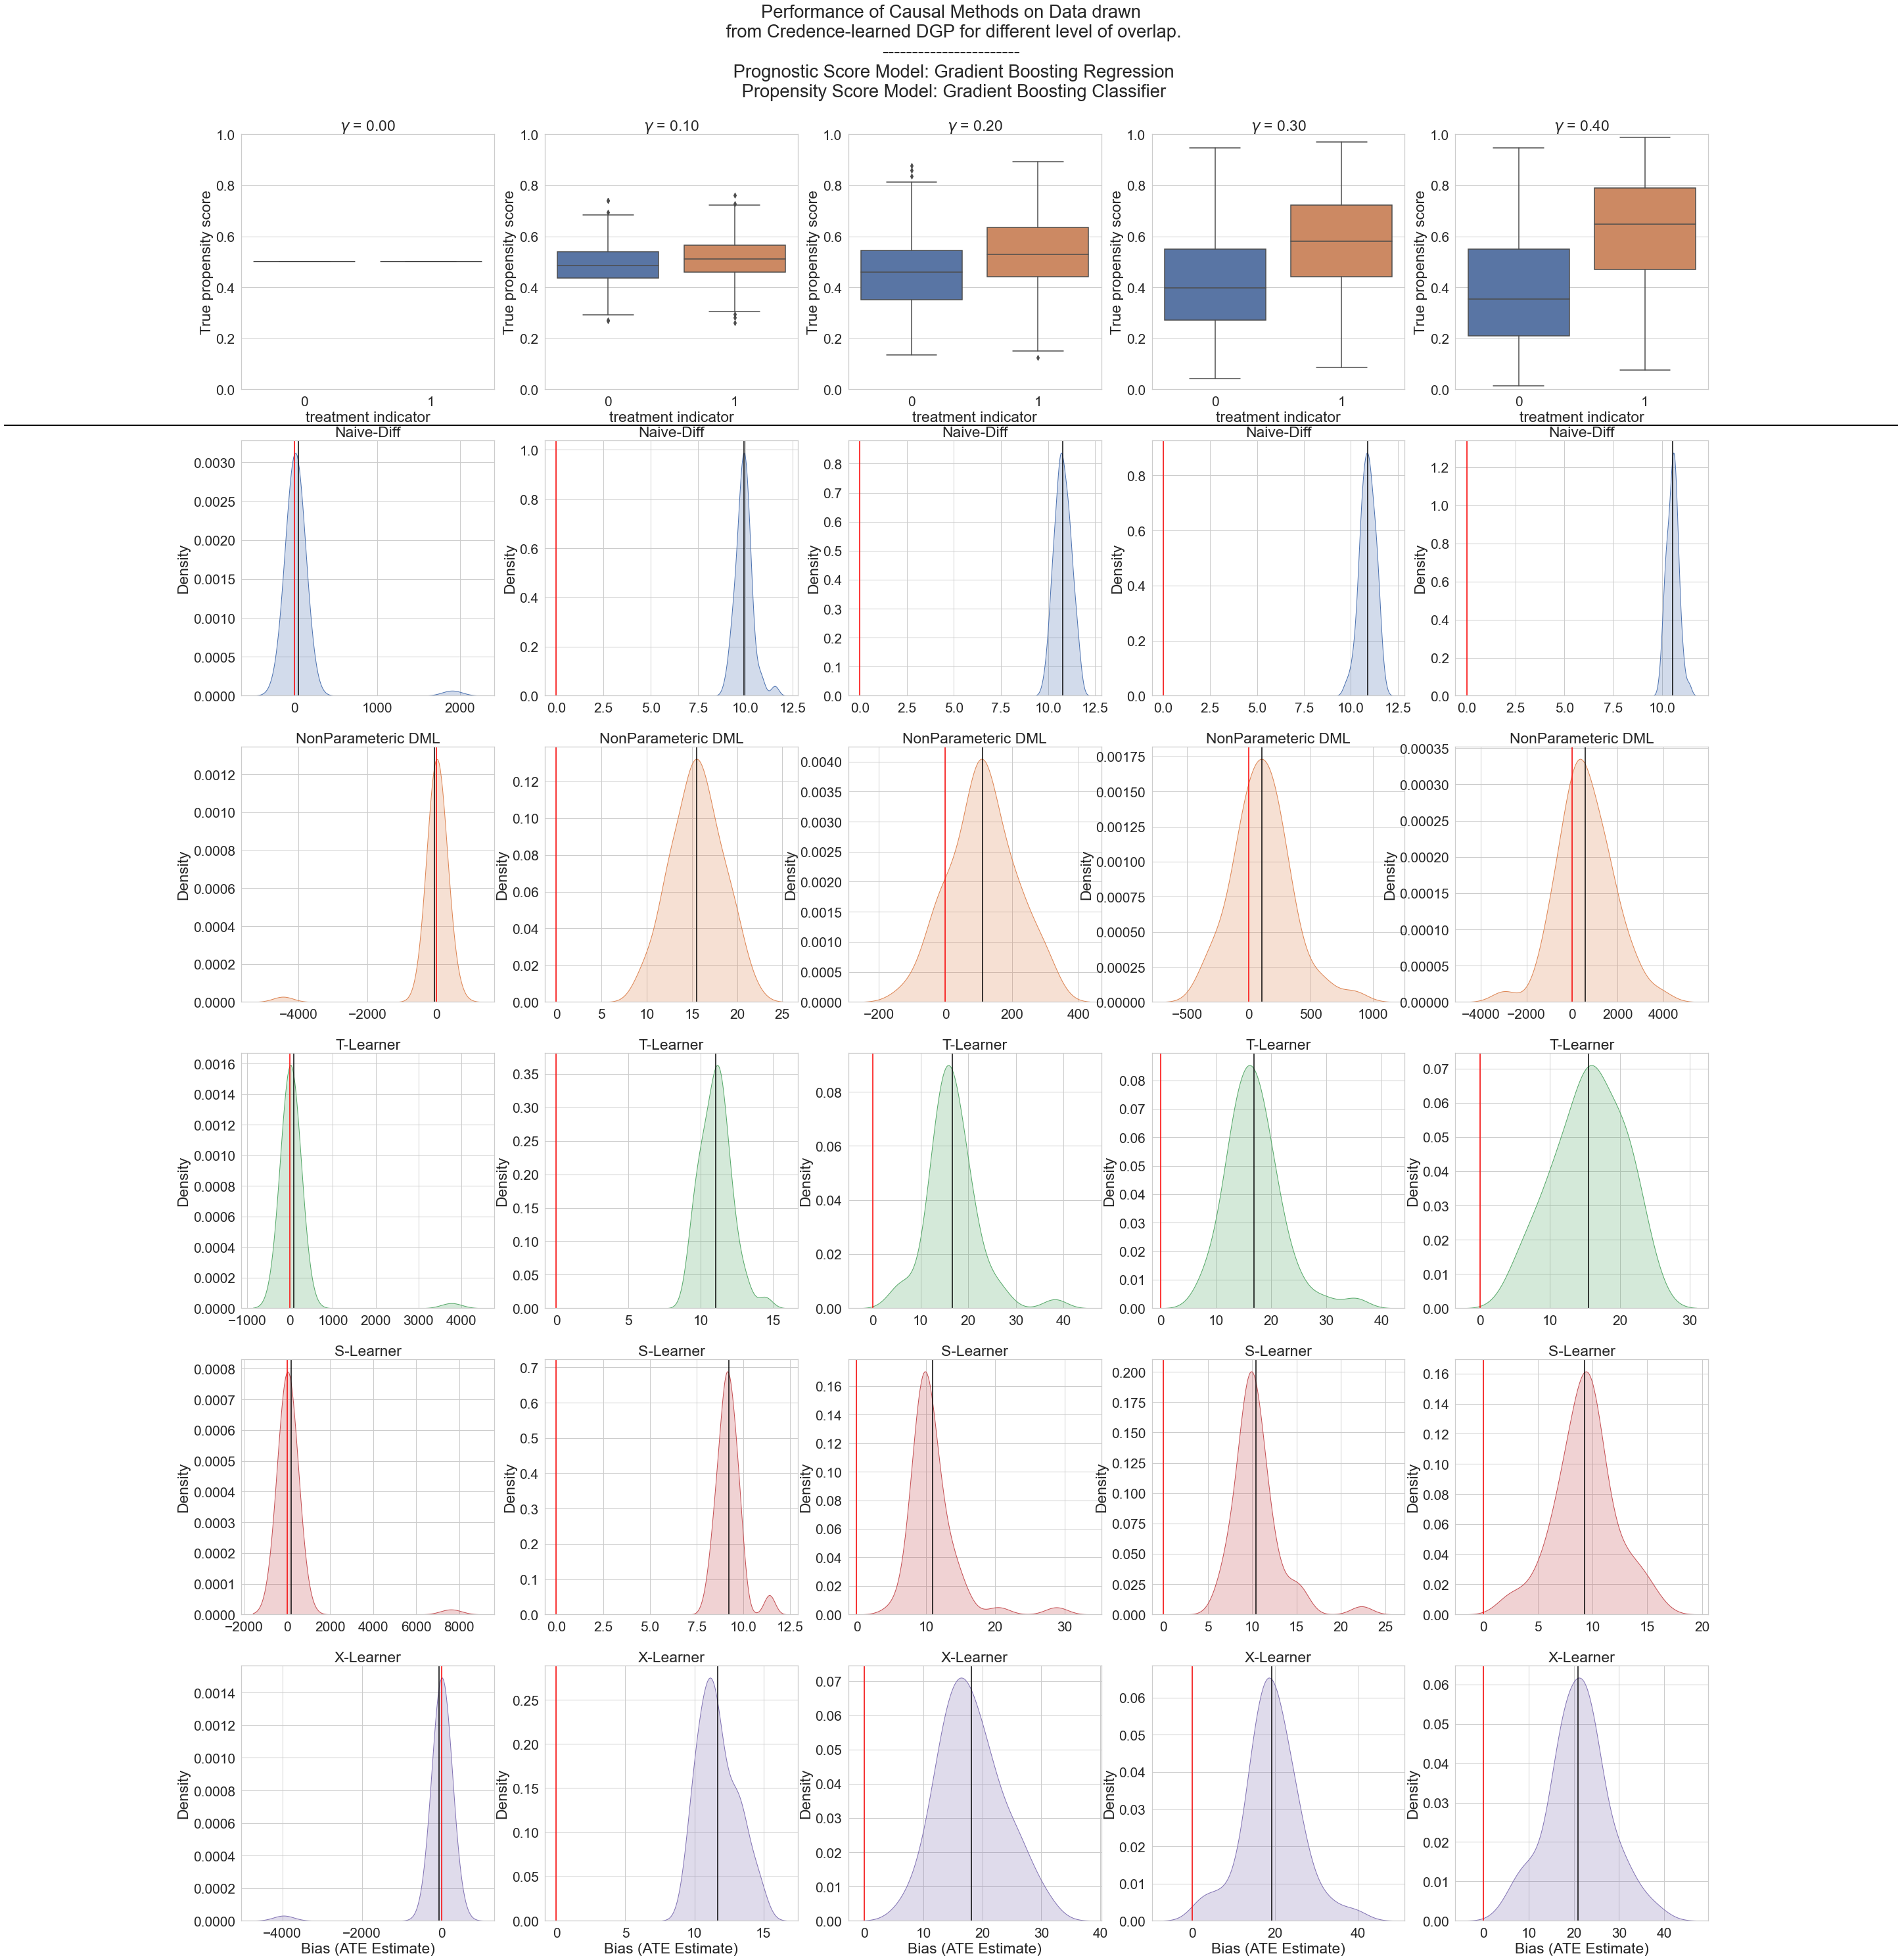

In [192]:
sns.set(style='whitegrid',font_scale=1.9)
Bias_bootstrap = df_bias_bootstrap.loc[df_bias_bootstrap['r']==0/10.0].drop(columns=['r'])
fig,ax = plt.subplots(figsize=(40,50),nrows=Bias_bootstrap.shape[0]+1,ncols=5,sharex=False,sharey=False)
plt.suptitle('Performance of Causal Methods on Data drawn\n from Credence-learned DGP for different level of overlap.\n-----------------------\n Prognostic Score Model: Gradient Boosting Regression\n Propensity Score Model: Gradient Boosting Classifier',
             va='top',ha='center',y=0.935)
for r in range(5):
    sns.boxplot(data=df_prop_score.loc[df_prop_score['r']==r/10.0],x='T',y='pi',ax=ax[0,r])
    ax[0,r].set_ylim((0,1))
    ax[0,r].set_title('$\gamma$ = %.2f'%(r/10.0))
    ax[0,r].set_ylabel('True propensity score')
    ax[0,r].set_xlabel('treatment indicator')
    Bias_bootstrap = df_bias_bootstrap.loc[df_bias_bootstrap['r']==r/10.0].drop(columns=['r'])
    line = plt.Line2D([0,1],[0.757,0.757], transform=fig.transFigure, color="black")
    fig.add_artist(line)
    for i in range(Bias_bootstrap.shape[0]):
        row = Bias_bootstrap.iloc[i]
        sns.kdeplot(row,ax=ax[i+1,r],fill=True,color='C%d'%(i))
        ax[i+1,r].axvline(np.mean(row),c='black')
        ax[i+1,r].set_title(df_bias_bootstrap.index[i])
        ax[i+1,r].axvline(0,c='red')
#         ax[i+1,r].set_xlim((-500,500))
        if (i+1)<Bias_bootstrap.shape[0]:
            ax[i+1,r].set_xlabel('')
        else:
            ax[i+1,r].set_xlabel('Bias (ATE Estimate)')
    # plt.xlim((-20,20))
plt.xlabel('Bias (ATE Estimate)')
plt.savefig('credence_synth_perf.png')

In [22]:
repeat=200

continuous_vars = ['X%d'%(i) for i in range(p)]+['Y']
categorical_var=['T']

Bias_truedgp = []
for itr in tqdm.tqdm(range(repeat)):
    Bias_est = {}
    df_gen,df_gen_true = dgp1(n,p)
    
#     df_gen['Y'] = df_gen['T']*df_gen['Y1'] + (1-df_gen['T'])*df_gen['Y0']

    true_te = df_gen_true['TE']
    selection_bias = 0 #df_gen_prime['T']*(df_gen_prime['Y1'] - df_gen_prime['Yprime1']) + (1-df_gen_prime['T'])*(df_gen_prime['Yprime0'] - df_gen_prime['Y0']) 
#     Bias_est['True-TE'] = true_te.mean()
#     Bias_est['selection-bias'] = selection_bias.mean()
    
#     df_gen = df_gen.drop(columns=['Y0','Y1'])

    Bias_est['Naive-Diff'] = (df_gen.loc[df_gen['T']==1,'Y'].mean() - df_gen.loc[df_gen['T']==0,'Y'].mean()) - (true_te+selection_bias).mean()
    #     print(ATE_est['Naive-Diff'])

    est = NonParamDML(model_y=GradientBoostingRegressor(),
                      model_t=GradientBoostingRegressor(),
                      model_final=GradientBoostingRegressor())
    est.fit(df_gen['Y'], 
            df_gen['T'], 
            X=df_gen.drop(columns=['Y','T']), 
            W=df_gen.drop(columns=['Y','T']))
    point = est.ate(df_gen.drop(columns=['Y','T']), 
                    T0=0, T1=1)

    Bias_est['NonParameteric DML'] = point - (true_te+selection_bias).mean()
    #     print(ATE_est['NonParameteric DML'])

    models = GradientBoostingRegressor()
    T_learner = TLearner(models=models)
    T_learner.fit(df_gen['Y'], df_gen['T'], X=df_gen.drop(columns=['Y','T']))
    point = T_learner.ate(X=df_gen.drop(columns=['Y','T']))
    Bias_est['T-Learner'] = point  - (true_te+selection_bias).mean()
    #     print(ATE_est['T-Learner'])

    models = GradientBoostingRegressor()
    S_learner = SLearner(overall_model=models)
    S_learner.fit(df_gen['Y'], df_gen['T'], X=df_gen.drop(columns=['Y','T']))
    point = S_learner.ate(X=df_gen.drop(columns=['Y','T']))
    Bias_est['S-Learner'] = point  - (true_te+selection_bias).mean()
    #     print(ATE_est['S-Learner'])

    models = GradientBoostingRegressor()
    propensity_model = LogisticRegressionCV()
    X_learner = XLearner(models=models,propensity_model=propensity_model)
    X_learner.fit(df_gen['Y'], df_gen['T'], X=df_gen.drop(columns=['Y','T']))
    point = X_learner.ate(X=df_gen.drop(columns=['Y','T']))
    Bias_est['X-Learner'] = point - (true_te+selection_bias).mean()
    #     print(ATE_est['X-Learner'])

    df_bias = pd.DataFrame.from_dict(Bias_est,orient='index',columns=['TE'])
    
    Bias_truedgp += [df_bias]
    
Bias_truedgp = pd.concat(Bias_truedgp,axis=1)

100%|██████████| 200/200 [06:45<00:00,  2.03s/it]


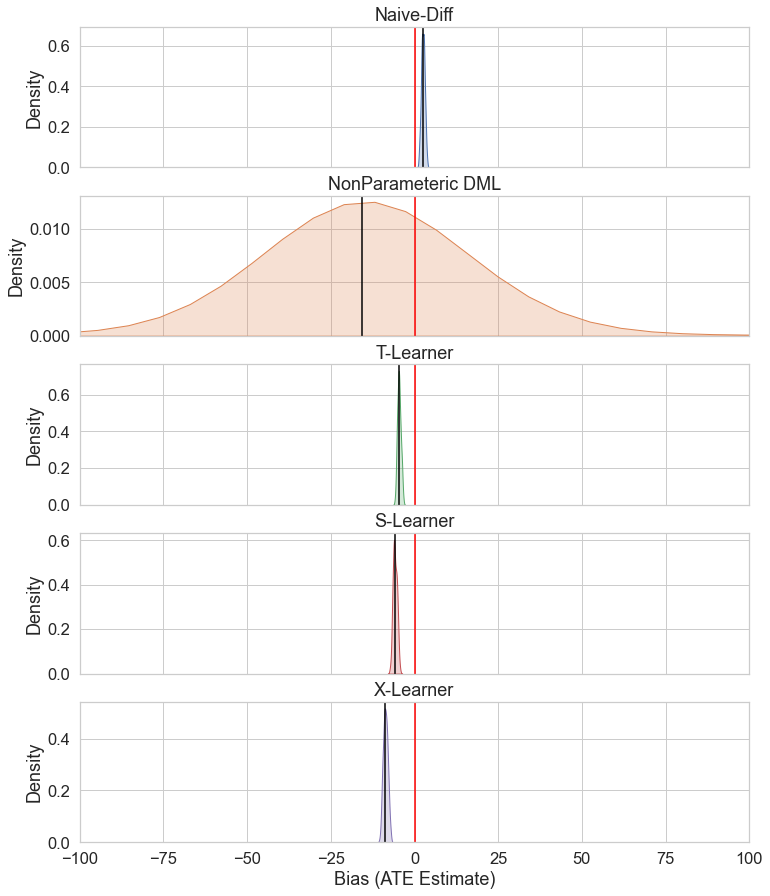

In [24]:
sns.set(style='whitegrid',font_scale=1.5)
fig,ax = plt.subplots(figsize=(12,15),nrows=Bias_truedgp.shape[0],sharex=True)
for i in range(Bias_truedgp.shape[0]):
    row = Bias_truedgp.iloc[i]
    sns.kdeplot(row,ax=ax[i],fill=True,color='C%d'%(i))
    ax[i].axvline(np.mean(row),c='black')
    ax[i].set_title(Bias_truedgp.index[i])
    ax[i].axvline(0,c='red')
plt.xlim((-100,100))
plt.xlabel('Bias (ATE Estimate)')
plt.savefig('true_synth_perf.png')